In [1]:

from fastcore.basics import store_attr
from fastcore.xtras import Path
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize, ColSplitter, RandomSplitter
from fastai.losses import FocalLossFlat
from fastai.losses import DiceLoss
from fastai.torch_core import tensor
from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats, SegmentationDataLoaders
from fastai.vision.learner import unet_learner
import numpy as np
from torchvision.models.resnet import resnet34
import torch
import torch.nn.functional as F
import boto3
import shutil
from tensorboard import notebook
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
import requests

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

from fastai.callback.tensorboard import TensorBoardCallback


In [3]:
import torch.cuda
torch.cuda.is_available()
torch.cuda.get_device_name(0)




'Tesla T4'

In [4]:
# You've got a few options for cities, I'll focus on just vegas for speed, but you'd have a lot of luck with combining the datasets
# Data is generarted by stage_1 in this directory if you wanted to download it yourself
#
url_list  = [
    'https://stephenbucketsagemaker.s3.amazonaws.com/AOI_2_Vegas_Train.tar.gz',
    'https://stephenbucketsagemaker.s3.amazonaws.com/AOI_3_Paris_Train.tar.gz',
    'https://stephenbucketsagemaker.s3.amazonaws.com/AOI_4_Shanghai_Train.tar.gz'
]

In [5]:
## Note, the data here is a derivative of the https://spacenet.ai/spacenet-buildings-dataset-v2 dataset
## Van Etten, A., Lindenbaum, D., & Bacastow, T.M. (2018). SpaceNet: A Remote Sensing Dataset and Challenge Series. ArXiv, abs/1807.01232.
## https://creativecommons.org/licenses/by-sa/4.0/



data_dir = Path().resolve() / "data"
if not data_dir.exists():
    data_dir.mkdir(parents=True)
unpacked_zips = []
# for the sake of download speed, I'm going to focus on the one AOI, Vegas, feel free to change this loop
# The model is pretty good with just vegas but does benefit from adding more locations in for the different building designs.
files_to_use = [x for x in url_list if 'Vegas' in x]

def download_file(file_url:str,to_file:Path) -> None:
    # Too much indentation for my brain to follow
    print("Downloading file")
    with requests.get(url=file_url,stream=True) as req:
        req.raise_for_status()
        with open(to_file,'wb') as fp:
            for chunk in req.iter_content(chunk_size=2**12):
                fp.write(chunk)
# __file__ doesnt exist in notebooks. I did not know that! so you'll see a lot of Path().resolve()\
for item in files_to_use:
    name_of_file = item.split("/")[-1]
    dir_name = data_dir / name_of_file
    extract_dir = dir_name.__str__().split('.')[0]
    if not Path(extract_dir).exists():
        Path(extract_dir).mkdir(parents=True)
    if not dir_name.exists():
        download_file(file_url=item,to_file = dir_name)
        shutil.unpack_archive(filename=dir_name,
                          extract_dir=extract_dir,
                          format='gztar')
        unpacked_zips.append(extract_dir)

In [6]:
# mask_files = (data_dir / s3_tar_gzs[0].split(".")[0] / "mask").glob("*.png")
# mask = PILMask.create(next(mask_files))
# mask.show()

In [7]:
# # labels in mask
# list(np.unique(tensor(mask)))
# # From data generation these will map to 0 = blank, 1 = footprint 2 = contact 3 = boundary
# # Anecdotally I've found that the contact layer especially helps the model distingish between building a lot better and prevents it from creating large blobs.

In [8]:
combined_dir = data_dir / "combined"
combined_img = combined_dir / "img"
combined_mask = combined_dir / "mask"
unpacked_zips = [Path(x) for x in unpacked_zips if isinstance(x,str)]
for  merge_locs in [combined_img,combined_mask]:
    if not merge_locs.exists():
        merge_locs.mkdir(parents=True)

for files in unpacked_zips:
    for folder in ["img","mask"]:
        for extension in ['*.jpg','*.png']:
            for item in (files / folder).glob(extension):
                dst_file = (combined_dir / folder / item.name ).__str__()
                shutil.copy(src= item.__str__(), dst= dst_file.__str__())

In [ ]:
fnames = get_image_files(combined_img)


def label_func(x:Path):
    return f"{combined_mask}/{x.stem}.png"

augs = [*aug_transforms(do_flip=False,flip_vert=False,max_rotate=0,max_zoom=1.3,
                                                  size=(360,360),)]


dls = SegmentationDataLoaders.from_label_func(path=combined_img,
                                              fnames=fnames,
                                              label_func=label_func,seed=42,
                                              batch_tfms=augs,bs=8,codes=["background","border","intersect","outline"]
)

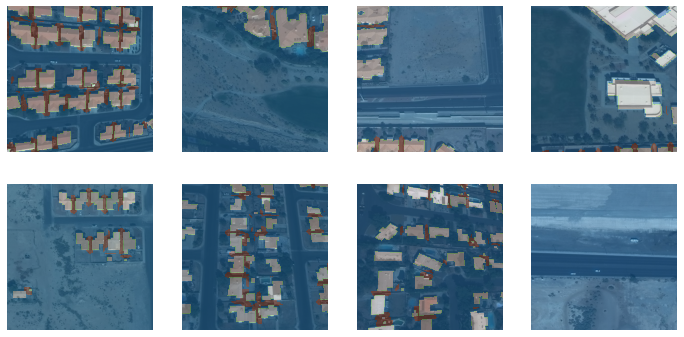

In [ ]:
dls.show_batch(max_n=9)
batch = dls.one_batch()

<AxesSubplot:>

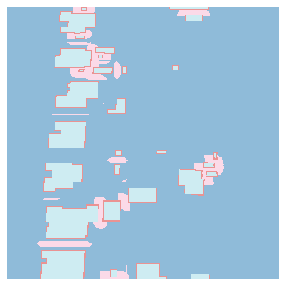

In [ ]:
batch[1][1].show()

<AxesSubplot:>

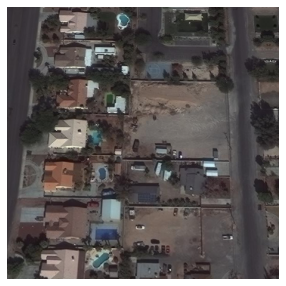

In [ ]:
batch[0][1].show()

In [ ]:
print (batch[0].size())
print(batch[1].size())

torch.Size([8, 3, 360, 360])
torch.Size([8, 360, 360])


In [ ]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.,gamma=3):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis,gamma=gamma)
        self.dice_loss =  DiceLoss(axis, smooth)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)



SuggestedLRs(valley=4.2352108721388504e-05)

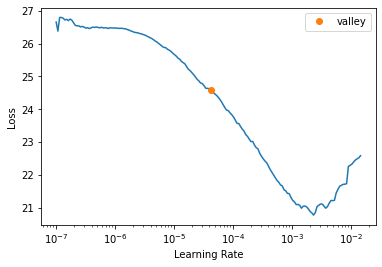

In [15]:
tensorboard_dir = Path().resolve() / 'model1_logs'
if not tensorboard_dir.exists():
    tensorboard_dir.mkdir(parents=True)
cbs = [TensorBoardCallback(log_dir= (tensorboard_dir /  "train_detect_building_no_unfreeze").__str__()),
                           ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2),
                           EarlyStoppingCallback(monitor='valid_loss')]

learn = unet_learner(dls,resnet34,self_attention=True,
                     loss_func=CombinedLoss(),cbs=cbs)

learn.lr_find(num_it=200,end_lr=8e-2)

In [16]:
%load_ext tensorboard
%tensorboard --logdir model1_logs
notebook.display(height=500)

Selecting TensorBoard with logdir model1_logs (started 0:00:01 ago; port 6006, pid 741).


In [17]:
learn.fit_one_cycle(10,4.5e-5)

epoch,train_loss,valid_loss,time
0,18.483374,17.496471,05:28
1,14.699542,13.615296,05:27
2,13.576114,13.255875,05:28
3,12.813314,11.901272,05:29
4,12.019904,11.593728,05:29
5,11.795763,11.294988,05:26
6,11.470395,11.138534,05:27
7,11.401296,10.963621,05:23
8,10.930306,10.888872,05:26
9,11.290785,10.888245,05:27


Epoch 9: reducing lr to 4.633201722536442e-11


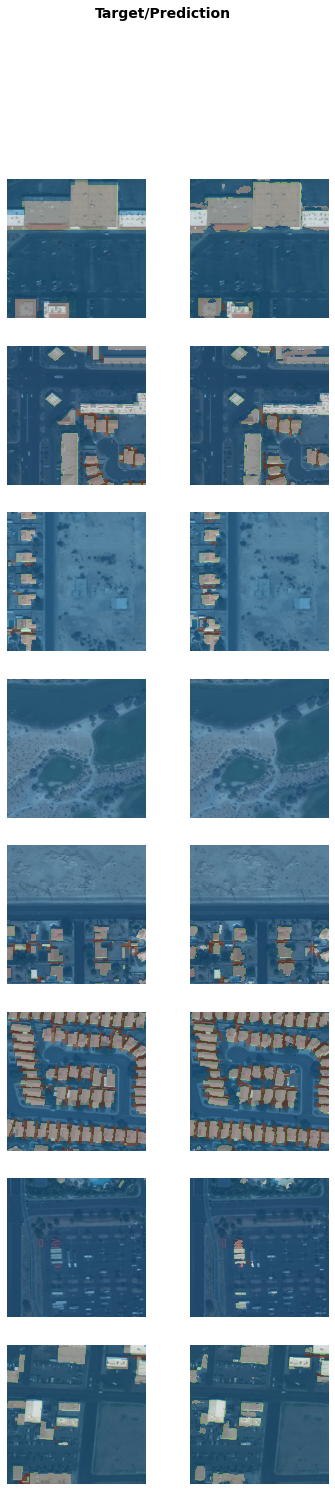

In [18]:
learn.show_results()

In [19]:
model_name = Path().resolve() / 'predict_footprint'
learn.export(model_name)
learn.save(model_name)
try:
    s3 = boto3.client('s3')
    with open(model_name.__str__(), 'rb') as fp:
        s3.upload_fileobj(fp, bucket_name, model_name.name +".model", ExtraArgs=dict(RequestPayer='requester',
                                                                     ACL='public-read'))
    with open(model_name.__str__() + '.pth', 'rb') as fp:
        s3.upload_fileobj(fp, bucket_name, model_name.name +".pth", ExtraArgs=dict(RequestPayer='requester',
                                                                     ACL='public-read'))
except:
    pass # If you don;t have AWS access then I'm not goign to force you to upload stuff

SuggestedLRs(valley=3.201016852472094e-06)

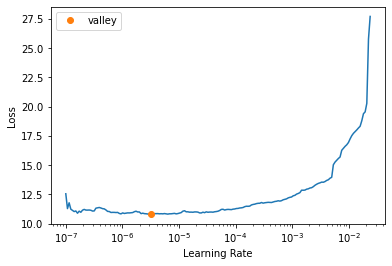

In [20]:
cb_index = [str(x) for x in learn.cbs].index("TensorBoardCallback")
learn.remove_cb(learn.cbs[cb_index])
learn.add_cb(TensorBoardCallback(log_dir= (tensorboard_dir /  "train_detect_building_unfreeze").__str__()))
learn.lr_find(num_it=200,end_lr=8e-2)

In [ ]:
# I have another option of doing add_cbs and remove_cbs, but this is more clear
# learn.cbs= cbs = [TensorBoardCallback(log_dir= (tensorboard_dir /  "train_detect_building_unfreeze").__str__()),
#                            ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2),
#                            EarlyStoppingCallback(monitor='valid_loss')]

learn.unfreeze()
learn.fit_one_cycle(10,slice(4.5e-9,3e-6))
learn.show_results()

epoch,train_loss,valid_loss,time
0,10.946656,10.901452,05:40
1,11.396557,10.880260,05:40
2,11.160177,10.821517,05:41


Epoch 2: reducing lr to 2.967560176856875e-07


In [ ]:
model_name = Path().resolve() / 'predict_footprint_fine_tuned'
learn.export(model_name)
learn.save(model_name)
try:
    s3 = boto3.client('s3')
    with open(model_name.__str__(), 'rb') as fp:
        s3.upload_fileobj(fp, bucket_name, model_name.name +".model", ExtraArgs=dict(RequestPayer='requester',
                                                                     ACL='public-read'))
    with open(model_name.__str__() + '.pth', 'rb') as fp:
        s3.upload_fileobj(fp, bucket_name, model_name.name +".pth", ExtraArgs=dict(RequestPayer='requester',
                                                                     ACL='public-read'))
except: pass